<h1>Testing the numerical matrix generation</h1>

Testing "matrix_building_numerical.py".

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import webbpsf

os.chdir('../python/')
from config import CONFIG_INI
import util_pastis as util

os.environ['WEBBPSF_PATH'] = CONFIG_INI.get('local', 'webbpsf_data_path')
print('Currenlty running on WebbPSF', webbpsf.version.version)

Currenlty running on WebbPSF 0.8.0


In [3]:
# Parameters
resDir = os.path.join(CONFIG_INI.get('local', 'local_data_path'), 'results')

#############################################################
#nb_seg = CONFIG_INI.getint('telescope', 'nb_subapertures')
nb_seg = 18       # just for now, to make testing faster
#im_size = CONFIG_INI.getint('numerical', 'im_size_px')
im_size = 128    # just for now, to make testing faster
#############################################################

inner_wa = CONFIG_INI.getint('coronagraph', 'IWA')
outer_wa = CONFIG_INI.getint('coronagraph', 'OWA')
sampling = CONFIG_INI.getfloat('numerical', 'sampling')
fpm = CONFIG_INI.get('coronagraph', 'focal_plane_mask')         # focal plane mask
lyot_stop = CONFIG_INI.get('coronagraph', 'pupil_plane_stop')   # Lyot stop
filter = CONFIG_INI.get('filter', 'name')
nm_aber = CONFIG_INI.getfloat('calibration', 'single_aberration_nm')
wss_segs = webbpsf.constants.SEGNAMES_WSS_ORDER
zern_max = CONFIG_INI.getint('zernikes', 'max_zern')
zern_number = CONFIG_INI.getint('calibration', 'zernike')
zern_mode = util.ZernikeMode(zern_number)                       # Create Zernike mode object for easier handling
wss_zern_nb = util.noll_to_wss(zern_number)                     # Convert from Noll to WSS framework

Some preliminary checking of the read-in parameters:

In [4]:
print('resDir:', resDir)
print('nb_seg:', nb_seg)
print('im_size:', im_size)
print('inner_wa:', inner_wa)
print('outer_wa:', outer_wa)
print('sampling:', sampling)
print('fpm:', fpm)
print('lyot_stop:', lyot_stop)
print('filter:', filter)
print('nm_aber:', nm_aber)
print('wss_segs:', wss_segs)
print('zern_max:', zern_max)
print('zern_number:', zern_number)
print(zern_mode.get_info())
print('wss_zern_nb:', wss_zern_nb)

resDir: /Users/ilaginja/Documents/data_from_repos/pastis_data/results
nb_seg: 18
im_size: 128
inner_wa: 6
outer_wa: 10
sampling: 2.0
fpm: MASK335R
lyot_stop: CIRCLYOT
filter: F335M
nm_aber: 1000.0
wss_segs: ('A1-1', 'A2-2', 'A3-3', 'A4-4', 'A5-5', 'A6-6', 'B1-7', 'C1-8', 'B2-9', 'C2-10', 'B3-11', 'C3-12', 'B4-13', 'C4-14', 'B5-15', 'C5-16', 'B6-17', 'C6-18')
zern_max: 11
zern_number: 1
This is Zernike mode 1 in the Noll convention, which is: piston
None
wss_zern_nb: 1


Creating a dark hole mask so that we can later overlay it with the images to extract the average contrast.

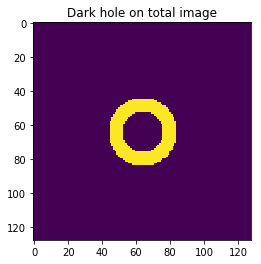

In [5]:
# Create the dark hole mask.
pup_im = np.zeros([im_size, im_size])    # this is just used for DH mask generation
dh_area = util.create_dark_hole(pup_im, inner_wa, outer_wa, sampling)

plt.imshow(dh_area)
plt.title('Dark hole on total image')
plt.show()

Setting up the webbpsf NIRCam object which we will control to move different segment pairs at a time and then generate an image.

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 9 steps


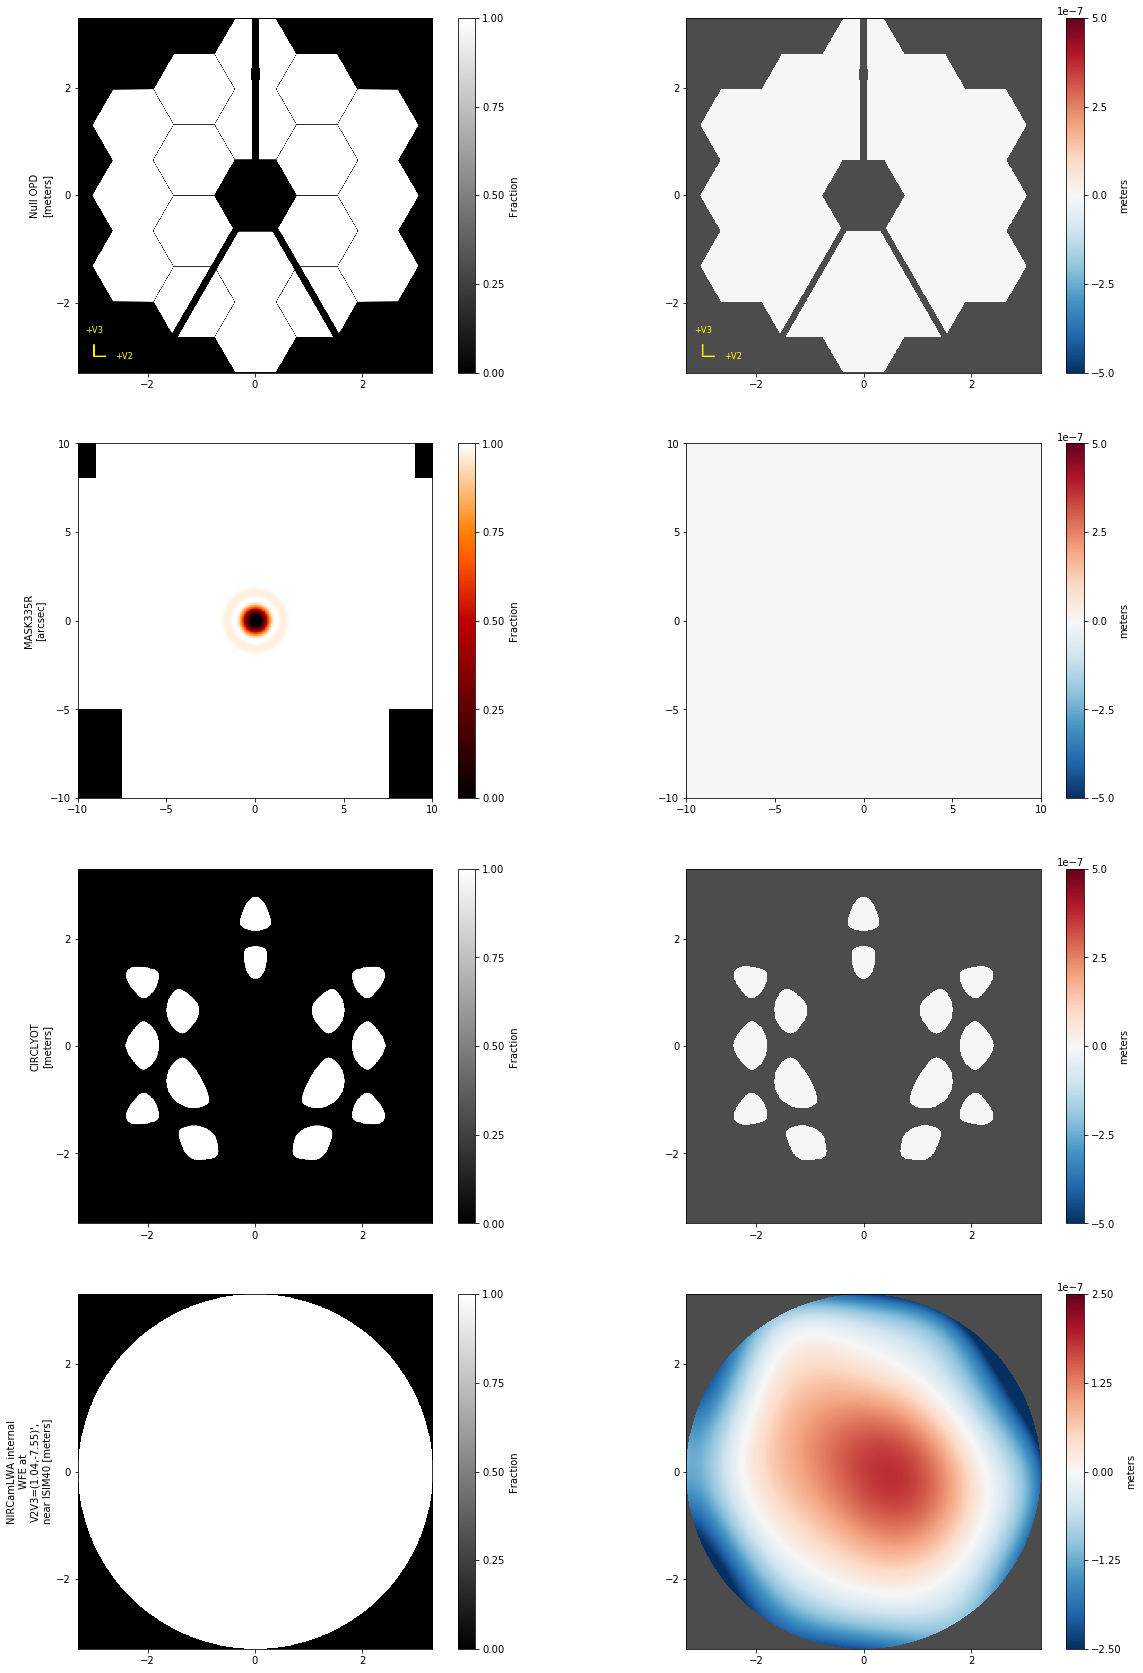

In [6]:
# Set up NIRCam object from WebbPSF
nc_coro = webbpsf.NIRCam()
nc_coro.filter = filter
nc_coro.image_mask = fpm
nc_coro.pupil_mask = lyot_stop

# Null the OTE OPDs for the PSFs, maybe we will add internal WFE later.
nc_coro, ote_coro = webbpsf.enable_adjustable_ote(nc_coro)      # create OTE for coronagraph
ote_coro.zero()    # Delete the OTE OPD

plt.figure(figsize=(20, 30))
nc_coro.display()
plt.show()

Next, making the loop to generate one image per aberrated segment pair i, j and feeding the resulting contrast into the matrix element [i, j].

STEP: 1-1 / 3-3


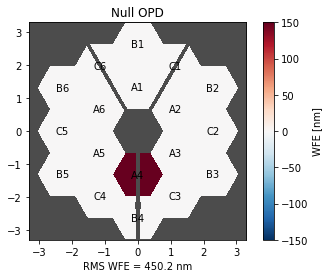

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


Calculating WebbPSF image
Calculating mean contrast in dark hole
contrast: 2.20024122113e-07


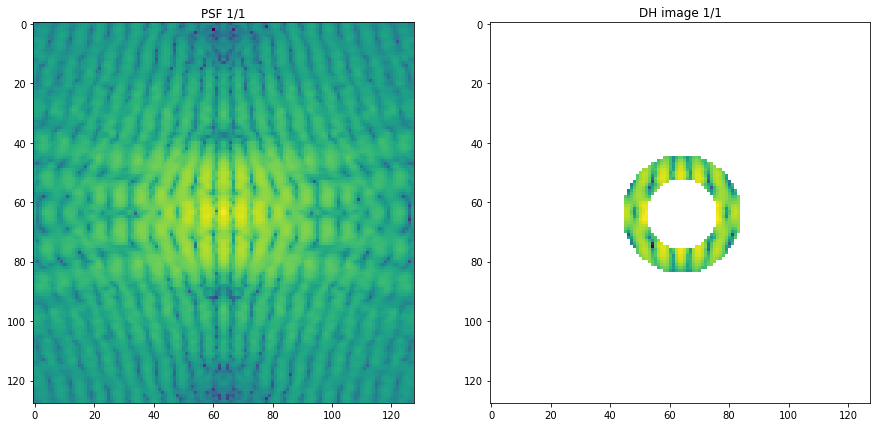

STEP: 1-2 / 3-3


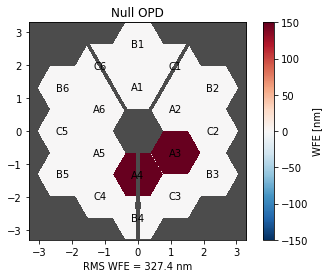

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


Calculating WebbPSF image
Calculating mean contrast in dark hole
contrast: 7.09072663781e-07


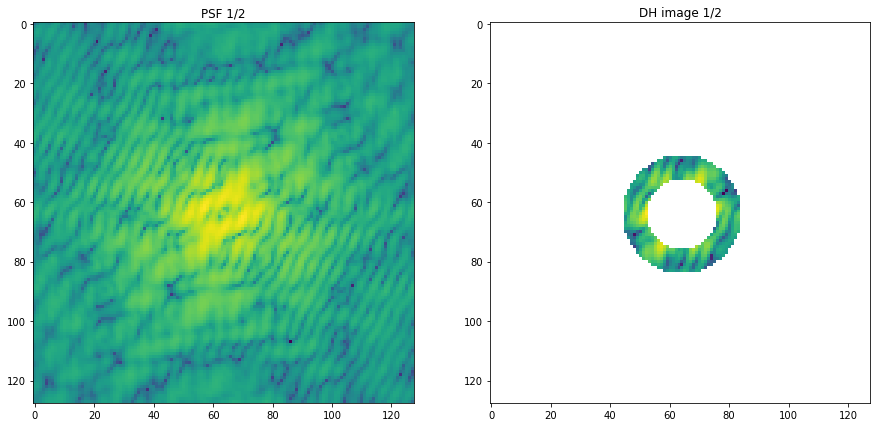

STEP: 1-3 / 3-3


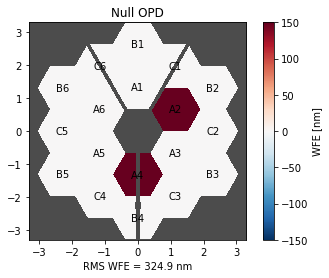

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


Calculating WebbPSF image
Calculating mean contrast in dark hole
contrast: 5.68638963323e-07


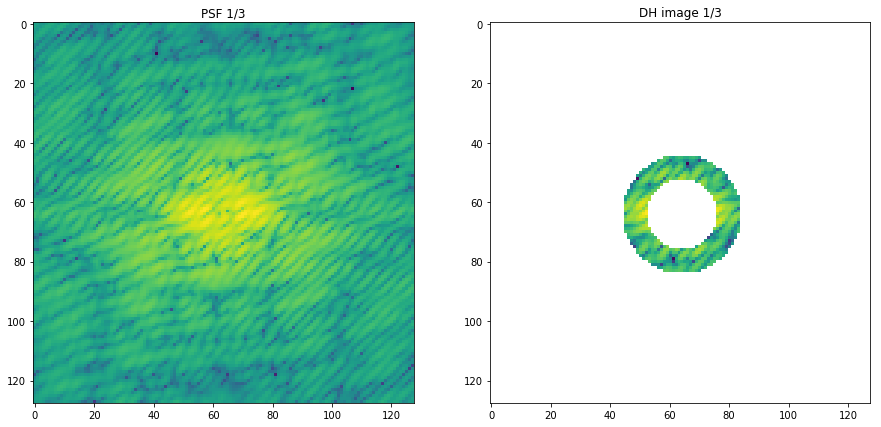

STEP: 2-1 / 3-3


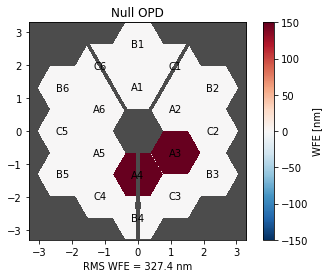

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


Calculating WebbPSF image
Calculating mean contrast in dark hole
contrast: 7.09072663781e-07


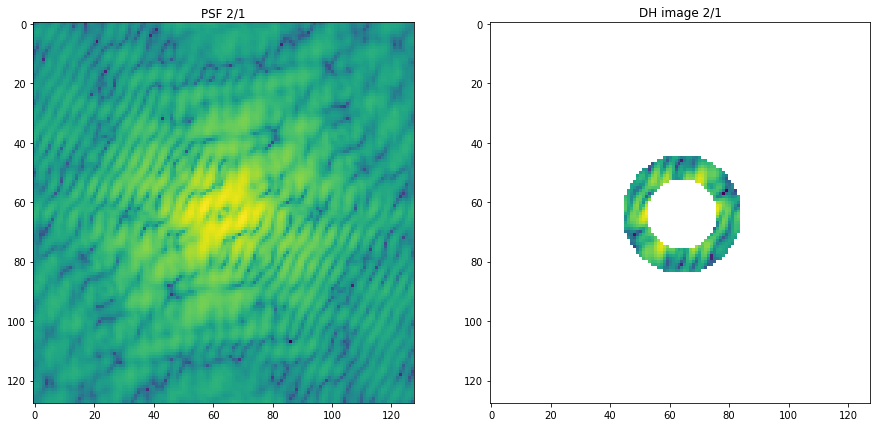

STEP: 2-2 / 3-3


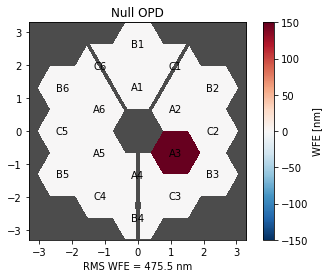

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


Calculating WebbPSF image
Calculating mean contrast in dark hole
contrast: 8.81982749844e-07


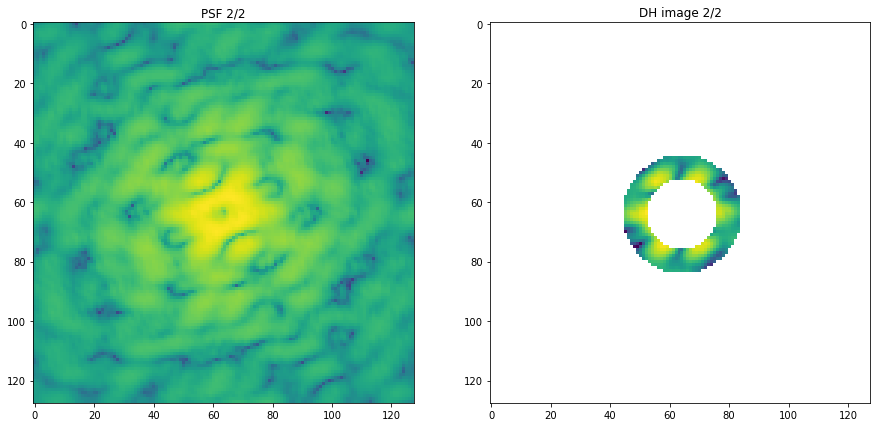

STEP: 2-3 / 3-3


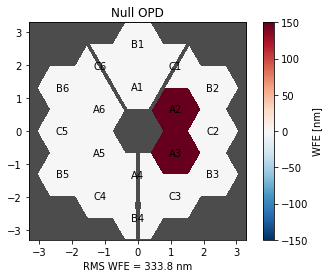

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


Calculating WebbPSF image
Calculating mean contrast in dark hole
contrast: 9.35096353779e-07


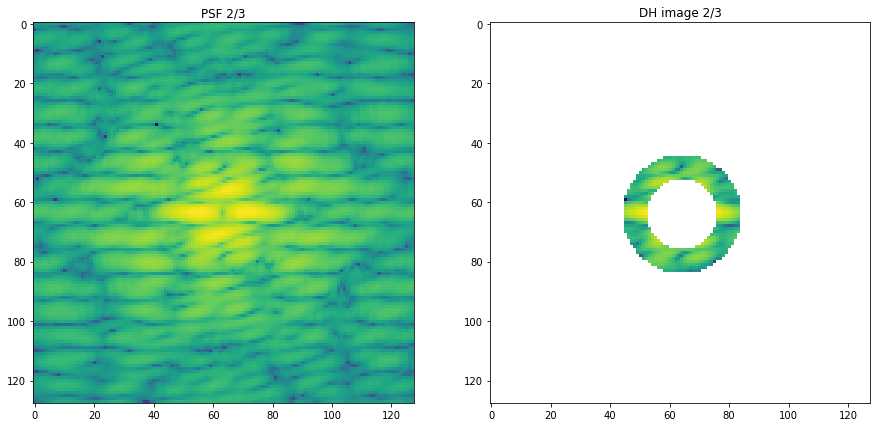

STEP: 3-1 / 3-3


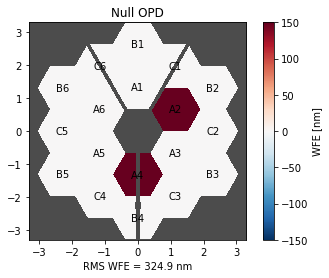

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


Calculating WebbPSF image
Calculating mean contrast in dark hole
contrast: 5.68638963323e-07


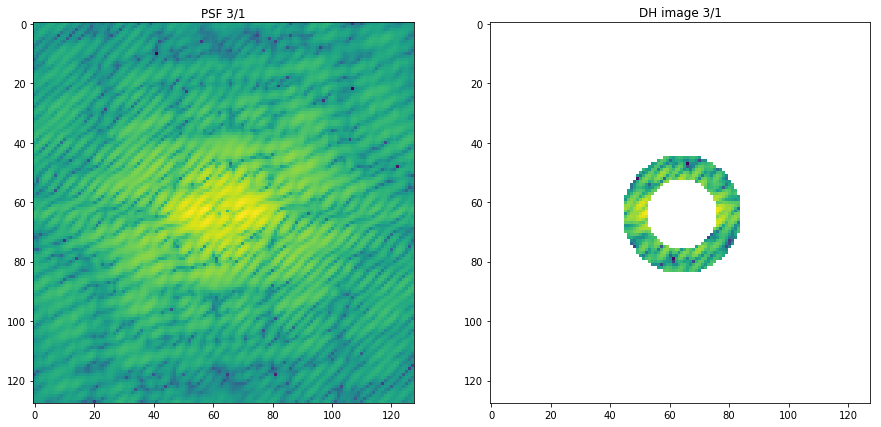

STEP: 3-2 / 3-3


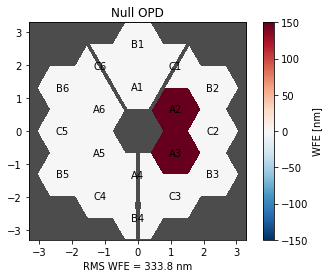

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


Calculating WebbPSF image
Calculating mean contrast in dark hole
contrast: 9.35096353779e-07


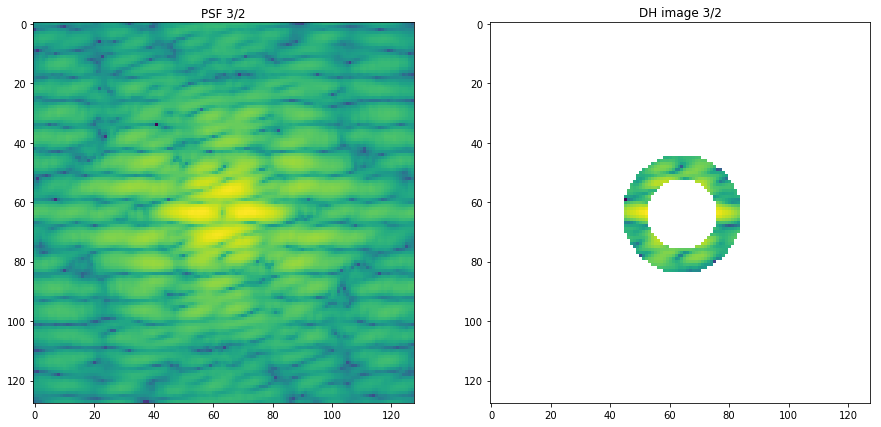

STEP: 3-3 / 3-3


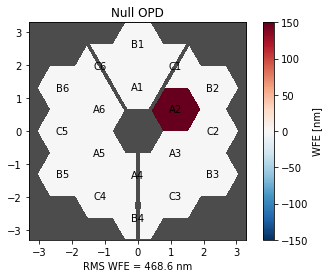

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


Calculating WebbPSF image
Calculating mean contrast in dark hole
contrast: 5.81386092274e-07


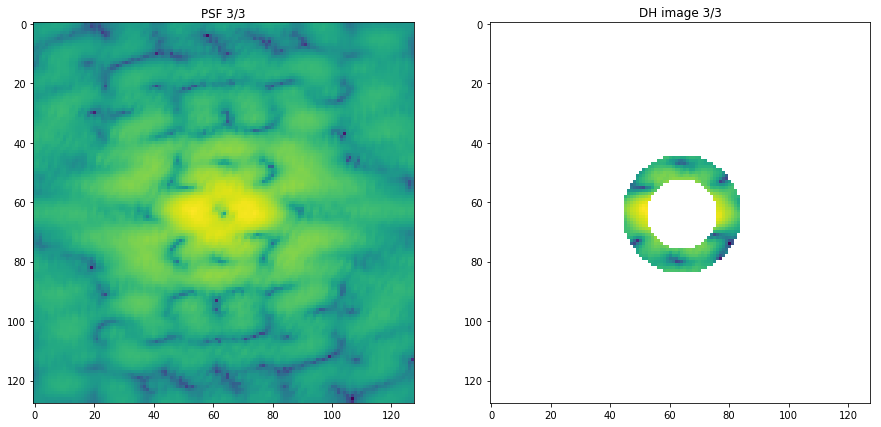

In [6]:
#-# Generating the PASTIS matrix
matrix_pastis = np.zeros([nb_seg, nb_seg])   # Generate empty matrix

for i in range(nb_seg):
    for j in range(nb_seg):

        print('STEP:', str(i+1) + '-' + str(j+1), '/', str(nb_seg) + '-' + str(nb_seg))
        
        # Get names of segments
        seg_i = wss_segs[i].split('-')[0]
        seg_j = wss_segs[j].split('-')[0]

        # Put the aberration on the correct segments
        Aber_WSS = np.zeros([nb_seg, zern_max])         # The Zernikes here will be filled in the WSS order!!!
                                                        # Because it goes into _apply_hexikes_to_seg().
        Aber_WSS[i, wss_zern_nb - 1] = nm_aber / 1e9    # Aberration on the segment we're currently working on;
                                                        # convert to meters; -1 on the Zernike because Python starts
                                                        # numbering at 0.
        Aber_WSS[j, wss_zern_nb - 1] = nm_aber / 1e9    # same for other segment

        # Putting aberrations on segments i and j
        ote_coro.reset()    # Making sure there are no previous movements on the segments.
        ote_coro.zero()     # set OTE for coronagraph to zero
        ote_coro._apply_hexikes_to_seg(seg_i, Aber_WSS[i, :])    # set segment i (segment numbering starts at 1)
        ote_coro._apply_hexikes_to_seg(seg_j, Aber_WSS[j, :])    # set segment j

        # If you want to display teh OTE
        ote_coro.display_opd()
        plt.show()
        
        print('Calculating WebbPSF image')
        image = nc_coro.calc_psf(fov_pixels=int(im_size), oversample=1, nlambda=1)
        psf = image[1].data
        
        print('Calculating mean contrast in dark hole')
        dh_intensity = psf * dh_area
        contrast = np.mean(dh_intensity[np.where(dh_intensity != 0)])
        print('contrast:', contrast)
        
        # If you want to display the PSF and DH image
        plt.figure(figsize=(15,10))
        plt.subplot(1, 2, 1)
        plt.imshow(psf, norm=LogNorm())
        plt.colorbar()
        plt.title('PSF ' + str(i+1) + '/' + str(j+1))
        plt.subplot(1, 2, 2)
        plt.imshow(dh_intensity, norm=LogNorm())
        plt.colorbar()
        plt.title('DH image ' + str(i+1) + '/' + str(j+1))
        plt.show()

        # Fill according entry in the matrix
        matrix_pastis[i,j] = contrast
        